In [1]:
import sys

In [2]:
sys.version

'3.11.4 | packaged by conda-forge | (main, Jun 10 2023, 18:08:17) [GCC 12.2.0]'

In [3]:
pip install openeo

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install openeo_pg_parser_networkx

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install openeo_processes_dask

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install dask_geopandas

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install planetary_computer

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install stac_validator

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install openeo-processes-dask[implementations]

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install openeo-processes-dask[ml]

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


# openEO test case

## Do some imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from openeo.local import LocalConnection

In [3]:
import openeo_pg_parser_networkx
import openeo_processes_dask

print(openeo_pg_parser_networkx.__version__)
print(openeo_processes_dask.__version__)

2023.8.0
2023.8.1


# Now start openEO

## Connect to local backend

In [4]:
local_conn = LocalConnection("./")

## Connect to STAC endpoint

In [5]:
stac_url = "https://geoservice.dlr.de/eoc/ogc/stac/v1/"

url = stac_url + "collections/S5P_TROPOMI_L3_P1D_O3/"

spatial_extent = {"east": 180.0, "south": -90.0,"west": -180.0, "north": 90.0}

## Define data cube

In [6]:
s5p_datacube = local_conn.load_stac(
    url=url,
    spatial_extent=spatial_extent,
    temporal_extent=["2023-08-01", "2023-08-15"],
    bands=["o3"]
)

## Build Process Graph

In [25]:
# task_reduce_x = task_reduce_time.reduce_dimension('x', reducer='mean', context={"ignore_nodata": True})
# task = s5p_datacube.apply_dimension(process=nan_mean_function_0, dimension="y")

In [8]:
task_reduce_time = s5p_datacube.reduce_dimension('time', reducer='max')

In [9]:
task_reduce_lon = task_reduce_time.reduce_dimension('x', reducer='max')

In [10]:
task_reduce_lon

In [31]:
print (task_reduce_lon.to_json())

{
  "process_graph": {
    "loadstac1": {
      "process_id": "load_stac",
      "arguments": {
        "bands": [
          "o3"
        ],
        "spatial_extent": {
          "east": 180.0,
          "south": -90.0,
          "west": -180.0,
          "north": 90.0
        },
        "temporal_extent": [
          "2023-08-01",
          "2023-08-15"
        ],
        "url": "https://geoservice.dlr.de/eoc/ogc/stac/v1/collections/S5P_TROPOMI_L3_P1D_O3/"
      }
    },
    "reducedimension1": {
      "process_id": "reduce_dimension",
      "arguments": {
        "data": {
          "from_node": "loadstac1"
        },
        "dimension": "time",
        "reducer": {
          "process_graph": {
            "max1": {
              "process_id": "max",
              "arguments": {
                "data": {
                  "from_parameter": "data"
                }
              },
              "result": true
            }
          }
        }
      }
    },
    "reducedimension2":

## Execute process graph

In [17]:
result = task_reduce_lon.execute()

In [18]:
result

<xarray.DataArray 'stackstac-c4beb88ace5048bb5fcaf49a9bb32887' (band: 1, y: 1800)>
dask.array<_nanmax_skip-aggregate, shape=(1, 1800), dtype=float64, chunksize=(1, 1024), chunktype=numpy.ndarray>
Coordinates: (12/23)
  * band                                 (band) <U2 'o3'
  * y                                    (y) float64 90.0 89.9 ... -89.8 -89.9
    s5p:l2_algorithm_version             <U22 'UPAS-O3-DOAS_CAL-5.1.0'
    s5p:datasource                       <U48 'Sentinel-5P, TROPOMI, space-bo...
    proj:bbox                            object {180.0, -180.0, 90.0, -90.0}
    processing:level                     <U2 'L3'
    ...                                   ...
    processing:facility                  <U41 'Remote Sensing Technology Inst...
    proj:shape                           object {1800, 3600}
    platform                             <U20 'Sentinel 5 Precursor'
    description                          <U104 'TROPOMI/S5P L3 data of ozone ...
    title                                <U2 'O3'
    epsg                                 int64 4326
Attributes:
    spec:                           RasterSpec(epsg=4326, bounds=(-180.0, -90...
    crs:                            epsg:4326
    transform:                      | 0.10, 0.00,-180.00|\n| 0.00,-0.10, 90.0...
    resolution:                     0.1
    reduced_dimensions_min_values:  {'time': numpy.datetime64('2023-08-01T00:...

## Show Result

Text(0, 0.5, 'Latitude [deg]')

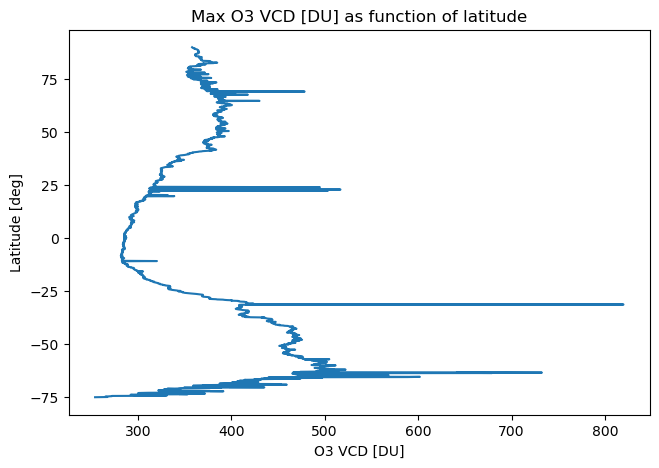

In [33]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1,figsize=(7.5,5))
ax.plot(result.values[0],result["y"][:])
ax.set_title ("Max O3 VCD [DU] as function of latitude")
ax.set_xlabel ("O3 VCD [DU]")
ax.set_ylabel ("Latitude [deg]")